# Fit Spikes of HH with AdEx

In [1]:
from brian2 import *
from brian2modelfitting import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(10*ms/dt)), np.zeros(int(5*ms/dt))])*2*nA

params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [12]:
I = TimedArray(input_current, dt=dt)

G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
                method='exponential_euler')
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)


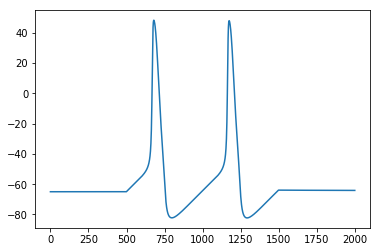

In [14]:
voltage = mon.v[0]/mV
plot(voltage);

In [20]:
spikes = [spike_mon.spike_trains()[0]/ms]
spikes

[array([ 6.55, 11.5 ])]

In [7]:
inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape
inp_trace.shape

(1, 1997)

In [8]:
out_trace = np.array([voltage[:n1]])
out_trace.shape

(1, 1997)

## AdEx

In [21]:
start_scope()

In [22]:
# Parameters
C = 171 * pF
# gL = 60 * nS
gL = 6.16243899e-08*siemens
taum = C / gL
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV
Vcut = VT + 50 * DeltaT

In [23]:
taum

2.77487534 * msecond

In [24]:
# Pick an electrophysiological behaviour
tauw, a, b, Vr = 124*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)


In [25]:
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
"""

In [26]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spikes = SpikeMonitor(neuron)

In [27]:
run(30*ms)

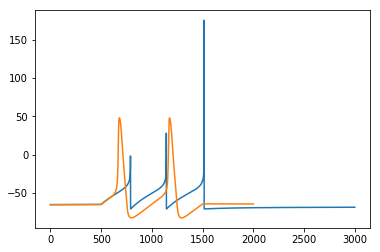

In [28]:
plot(trace[0].vm/mV)
plot(voltage);

## Model Fitting

In [34]:
eqs = Equations(
"""
taum = C / gL : second
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
gL: siemens(constant)
C: farad (constant)
""", 
# C = 171 * pF,
# gL = 60 * nS,
EL = -65 * mV,
VT = -50.4 * mV,
DeltaT = 5 * mV,
Vcut = VT + 50 * DeltaT,    
tauw = 144*ms,
a = 4*nS,
b = 0.0805*nA,
Vr = -70.6*mV)

In [35]:
n_opt = NevergradOptimizer()
metric = GammaFactor(dt, 30*ms)
inp_trace = np.array([input_current])

In [36]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                     input=inp_trace * amp, output=spikes,
                     n_samples=30,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     param_init={'v': -70*mV},
                     )

In [37]:
result_dict, error = fitter.fit(n_rounds=2,
                                optimizer=n_opt,
                                metric=metric,
                                callback='progressbar',
                                gL=[20*nS, 40*nS],
                                C = [0.5*nF, 1.5*nF])

WARNING    "gL" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 61.6243899 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "C" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 171. * pfarad. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


TypeError: 'SpikeMonitor' object is not subscriptable

In [ ]:
print('goal:', {'gL': 30*nS, 'C':1*nF})
print('results:', result_dict['C']*farad, result_dict['gL']*siemens)

# visualization of the results
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
spikes = fitter.generate_spikes(params=None, param_init={'v': -70*mV})
print('spike times:', spikes)

EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
fits = fitter.generate(params=None,
                       output_var='v',
                       param_init={'v': -70*mV})

# Vizualize the resutls
plot(voltage);
plot(fits[0]/mV)
plt.show()